# Toxic Comment Classification Challenge
Given a comment, identify the following labels associated with it:
* Toxic 
* Severetoxic
* Obscene
* threat
* Insult
* Identityhate

This is a **multi-label classification**, meaning, that a comment can belong to zero or more labels at the same time.
The evauation metric used has been mean column-wise ROC AUC. 

This notebook has been divided into following sections:

1. Importing the libraries
2. Reading the Training dataset
3. Performing EDA
4. Preprocessing of the Text
5. Defining the Model
6. Training
7. Testing
***
### Importing the libraries  

In the block below, required libraries for this notebook has been imported.

In [1]:
"""Importing the required libraries"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.layers import *
from keras import backend, Model

Using TensorFlow backend.


### Reading the Training dataset

In [2]:
"""Reading the training dataset and performing the EDA ( Exploratory Data Analysis ) in the upcoming cells"""

path = '../input/'
comp = 'jigsaw-toxic-comment-classification-challenge/'
dataset = pd.read_csv('../input/train.csv')

### Performing EDA  
EDA is Exploratory Data Analysis which is basically analysis of the data you have been given before you can start working on it.


In [3]:
"""Performing EDA ( Exploratory Data Analysis ) """


#Having a look at the data
print("Number of rows in data = ", dataset.shape[0])
print("Number of columns in data = ", dataset.shape[1])
print("\n")
print("---Sample data---")
dataset.head()

Number of rows in data =  159571
Number of columns in data =  8


---Sample data---


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


***
Having a look at the plot of Comments vs. Label.  
This will give us the count of the comments belonging to each label.  
**Note**: A comment can belong to several labels ( multi-label classification )

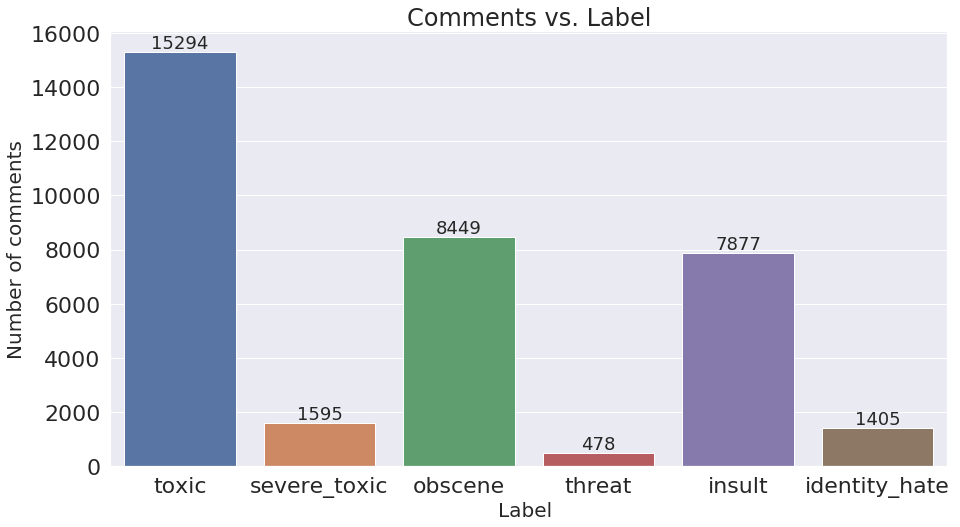

In [4]:
"""Performing EDA ( Exploratory Data Analysis ) """

#Visualising the Training data : Number of comments vs. Label
labels = dataset.columns.values[2:]
labels_count = dataset.iloc[:, 2:].sum().values
sns.set(font_scale = 2)
plt.figure(figsize = (15, 8))
fig = sns.barplot(labels, labels_count)
plt.title("Comments vs. Label", fontsize = 24)
plt.ylabel('Number of comments', fontsize = 20)
plt.xlabel('Label ', fontsize = 20)
rects = fig.patches
for rect, label in zip(rects, labels_count):
    height = rect.get_height()
    fig.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = 'center', va = 'bottom', fontsize = 18)
plt.show()

### Preprocessing of the Text

Better the data, better the model. Henceforth, text will be preprocessed.  
Preprocessing involves cleaning the data like, removing HTML tags, stop-words, non-ASCII characters, converting to lowercase etc.

In [5]:
"""Function for Text Preprocessing"""

#Removing non-english symbols, HTML tags, converting to lower-case, lemmatizing, and finally removing the stop-words 
stop_words = set(stopwords.words("english")) 
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
lemmatizer = WordNetLemmatizer()

def clean_text(X):
    processed = []
    for text in X:
        text = text[0]
        text = re.sub(r'[^\w\s]', '',text, re.UNICODE)
        text = re.sub('\n', ' ',text, re.UNICODE)
        text = re.sub('<.*?>', '', text)
        text = text.lower()
        text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
        text = [lemmatizer.lemmatize(token, "v") for token in text]
        text = [word for word in text if not word in stop_words]
        processed.append(text)
    return processed

Preprocessing the data so as to prepare the Training set

In [6]:
"""Getting the X and Y and preprocessing them"""

X = dataset.iloc[:, 1:2].values
y_train = dataset.iloc[:, 2:8].values
X_train = clean_text(X)

Tokenizing the comments and converting them into a sequence of integers of fixed length( maxlen ).  
Neural networks are basically mathematical models, they can't accept characters.

In [7]:
"""Tokenization and Padding"""
vocab_size = 10000
maxlen = 250
embed_dim = 20
batch_size = 64
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenized_word_list = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(tokenized_word_list, maxlen = maxlen, padding='post')

#### EarlyStopping  
It can be used to prevent overfitting.It basically waits a few epochs (2), monitoring the loss for the validation dataset.If the loss doesn't decrease for 2 epochs, it stops the training process.

#### ModelCheckpoint
It is used for saving the best model during training. After each epoch, it takes a look at the Validation accuracy, if it improves globally, this is the best model we have seen till now during the training process and hence, saves it.

In [8]:
"""EarlyStopping and ModelCheckpoint"""

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)
mc = ModelCheckpoint('model_best.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

### Defining the Model
I have used TextCNN with 64 filters of size 3 and 5 each, followed by GlobalMaxPool (both 1-D) and concatenated their output


In [9]:
"""Creating TextCNN model for comment classification"""

#Defining the Layers of the model
input_X = Input(shape=(maxlen, ))
embed = Embedding(vocab_size, embed_dim)(input_X)
conv_1 = Conv1D(filters = 32, kernel_size = 2, activation = 'relu', padding = 'valid')(embed)
out_1 = GlobalMaxPooling1D()(conv_1)
conv_2 = Conv1D(filters = 32, kernel_size = 4, activation = 'relu', padding = 'valid')(embed)
out_2 = GlobalMaxPooling1D()(conv_2)
conc = concatenate([out_1, out_2])
dense1 = Dense(32, activation = 'relu')(conc)
out = Dense(6, activation = 'sigmoid', name = 'output_layer')(dense1)

#Defining the model now
model = Model(input_X, out)
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 20)      200000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 249, 32)      1312        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 247, 32)      2592        embedding_1[0][0]                
__________________________________________________________________________________________________
global_max

### Training
Training the Model using 20% of the training set as validation set

In [10]:
"""Fitting the model"""
X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y_train, test_size = 0.2, random_state = 42, shuffle = True)
model.fit(X_train, y_train, epochs = 10, batch_size = batch_size, verbose = 1, validation_data = [X_val, y_val], callbacks = [es, mc])

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 20s 158us/step - loss: 0.1106 - acc: 0.9684 - val_loss: 0.0677 - val_acc: 0.9778

Epoch 00001: val_acc improved from -inf to 0.97781, saving model to model_best.h5
Epoch 2/10
127656/127656 [==============================] - 13s 105us/step - loss: 0.0594 - acc: 0.9796 - val_loss: 0.0578 - val_acc: 0.9801

Epoch 00002: val_acc improved from 0.97781 to 0.98006, saving model to model_best.h5
Epoch 3/10
127656/127656 [==============================] - 13s 104us/step - loss: 0.0519 - acc: 0.9814 - val_loss: 0.0545 - val_acc: 0.9808

Epoch 00003: val_acc improved from 0.98006 to 0.98077, saving model to model_best.h5
Epoch 4/10
127656/127656 [==============================] - 13s 104us/step - loss: 0.0478 - acc: 0.9824 - val_loss: 0.0537 - val_acc: 0.9809

Epoch 00004: val_acc improved from 0.98077 to 0.98086, saving model to model_best.h5
Epoch 5/10
127656/127656 [==================

### Testing
Importing the test set and making it ready 

In [11]:
"""Importing the Test Data and making it ready to be passed to the Model"""

dataset2 = pd.read_csv('../input/test.csv')
X_test = dataset2.iloc[:, 1:2].values
X_test = clean_text(X_test)
tokenized_word_list = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(tokenized_word_list, maxlen = maxlen, padding='post')

In [12]:
"""Testing and creating the test results"""

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
model = load_model('model_best.h5')
y_test = model.predict(X_test_padded, batch_size = 512, verbose = 1)
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
sample_submission[labels] = y_test
sample_submission.to_csv('submission.csv', index = False)

153164/153164 [==============================] - 1s 5us/step
